# Обновляем Fast AI

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


Проверяем версию

In [2]:
from fastai.version import __version__; __version__

'1.0.50.post1'

Документация по фреймворку Fast AI по работе с текстом: https://docs.fast.ai/text.html

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [0]:
import os
from tqdm import tqdm_notebook

# Подготавливаем данные

Сохраните данные для обучени и модели на свой Google-диск:

https://drive.google.com/open?id=1rKZLehhvsveyYQoTFreZ3DtQPyaRkXUL


In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ROOT_PATH = Path(root_dir + '/ml')

In [0]:
list(ROOT_PATH.iterdir())

[PosixPath('/content/gdrive/My Drive/ml/kinopoisk'),
 PosixPath('/content/gdrive/My Drive/ml/russian_lm')]

In [0]:
DATA_PATH = ROOT_PATH/'kinopoisk'/'data'

In [0]:
list(DATA_PATH.iterdir())

[PosixPath('/content/gdrive/My Drive/ml/kinopoisk/data/train_reviews.json'),
 PosixPath('/content/gdrive/My Drive/ml/kinopoisk/data/valid_reviews.json'),
 PosixPath('/content/gdrive/My Drive/ml/kinopoisk/data/kinopoisk_data_clas_clear.pkl'),
 PosixPath('/content/gdrive/My Drive/ml/kinopoisk/data/kinopoisk_lm_data.pkl'),
 PosixPath('/content/gdrive/My Drive/ml/kinopoisk/data/kinopoisk_clas_data.pkl')]

In [0]:
names = ['valid', 'train']
df_val, df_trn = [pd.read_json(DATA_PATH/f'{name}_reviews.json', lines=True) for name in names]

In [0]:
df_val.head()

,filmId,numOfDislikes,numOfLikes,reviewBody,reviewTitle,status
0,6034,1,19,"Бен Стиллер никогда не был выдающимся актером,...",«Иногда лучше не нарушать волшебство»,good
1,430593,0,2,"Начать хочется с того, что это прекрасный филь...",Мысли о прошлом и есть моё будущее.,good
2,777896,1,5,Сценаристка Анна и ее бойфренд Пол приезжают в...,Возвращайся в сон,bad
3,221750,13,14,"В 21 веке жанр хоррора был расширен еще одним,...",Типичнейший японский ужастик по-голливудски,bad
4,540632,0,1,"Мы привыкли к тому, что индийское кино изобилу...","Малоизвестные мультфильмы, к сожалению. Часть ...",good


In [0]:
df_trn.shape, df_val.shape

((11272, 6), (3750, 6))

In [0]:
df_val['valid'] = True
df_trn['valid'] = False
df_all = pd.concat((df_trn, df_val))

In [0]:
df_all.shape

(15022, 7)

# Языковая модель

## Подготовка данных

**BatchSize** - основной гиперпараметр сети, определяющий кол-во одновременно обрабатываемых обучающих примеров

In [0]:
bs = 32

Можно посмотреть определение любой интересующей функции

In [0]:
TextList.split_from_df??

Определяем набор данных, с помощью читабельного fluid-api:

In [0]:
vocab = Vocab.load(ROOT_PATH/'kinopoisk'/'models'/'kinopoisk_lm_vocab.pkl')

In [0]:
data = TextList.from_df(df_all, cols='reviewBody',
                        processor=[TokenizeProcessor(tokenizer=Tokenizer(lang="xx")), 
                                   NumericalizeProcessor(vocab=vocab)]).\
                split_from_df('valid').\
                label_for_lm().\
                databunch(bs=bs)

Сохраняем данные для того, чтобы в следующий раз не приходилось заново обрабатывать текст

In [0]:
data.save(DATA_PATH / "kinopoisk_lm_data.pkl")

In [0]:
data = load_data(DATA_PATH, "kinopoisk_lm_data.pkl", bs)

### Посмотрим как выглядят данные

In [0]:
data.show_batch()

idx,text
0,"равно идут немного мурашки . \r \n \r \n xxmaj сюжет конечно не новый . xxmaj шестеро ребят привозят на xxunk тюрьму снимать реалити - шоу , конечно с весьма xxunk xxunk , ну а ради денег люди готовы на многое , даже перешагнуть сквозь собственные страхи . xxmaj однако это не единственная xxunk к xxunk , в игру внезапно для всех вступает новый игрок ... \r \n \r"
1,"итог : « xxmaj коматозники » - это не просто добротный триллер с мистическим уклоном , интригующими событиями и великолепным актерским составом , но еще и кино , которому есть что сказать зрителю . < / b > \r \n \r \n < i>- xxmaj сегодня хороший день чтобы умереть … < / i > xxbos xxmaj простите , но так xxunk xxunk - просто кощунственно . \r \n"
2,"некоторые , ранее не известные факты . в плане эффектности ' xxmaj преисподняя ' ни чуть не уступает ' xxmaj суспирии ' - первой части трилогии , но сильно проигрывает ' xxmaj матери слёз ' , которая вопреки xxunk зрителей выдалась отличным хоррором . \r \n \r \n xxmaj основное действие фильма развивается в xxmaj нью - xxmaj йорке - городе , где находится дом второй матери , построенный"
3,"как бы подспудно развивая эту тему , взялся за прозу xxmaj xxunk xxmaj xxunk « xxmaj сандро из xxmaj xxunk » , в которой писатель дал весьма xxunk , неоднозначную оценку не только тому времени , но и самому xxmaj xxunk xxmaj xxunk . xxmaj справедливости ради , стоит признать то , что оба эти фильма получились у в общем то у крайне посредственного режиссёра довольно хорошо , каждый"
4,"друг с друга - экранная пара у них не вышла . xxmaj чан сам по себе , и xxmaj такер тоже . \r \n \r \n xxmaj нет основных элементов заявленного жанра : погонь , зрелищных перестрелок и головокружительных трюков . xxmaj впрочем , трюки есть , но сделаны они под стать xxmaj джеки , притом что уже возрастной актер выполняет их через силу . xxmaj совсем не утонуть"


In [0]:
data.train_ds[0][0]

Text xxbos xxmaj фильм довольно интересный . с самого начала интригует , интересно узнать что будет дальше . xxmaj нет ненужных и длительных диалогов . 
 
 
 
  xxmaj музыка . xxmaj как и во всех ужасах довольно xxunk . xxmaj здесь она играет большую роль . 
 
 
 
  xxmaj даже с точки зрения психологии фильм интересен , даже когда в фильме не появляется призрак и ты смотришь просто на игру участников , всё равно идут немного мурашки . 
 
 
 
  xxmaj сюжет конечно не новый . xxmaj шестеро ребят привозят на xxunk тюрьму снимать реалити - шоу , конечно с весьма xxunk xxunk , ну а ради денег люди готовы на многое , даже перешагнуть сквозь собственные страхи . xxmaj однако это не единственная xxunk к xxunk , в игру внезапно для всех вступает новый игрок ... 
 
 
 
  xxmaj концовка в фильме будто - бы постоянно меняется . xxmaj начало ты смотришь и думаешь ну вот и конец , однако фильм продолжаться и тем как он закончиться - вам стоит посмотреть .

Каждому слову -(токену) ставится в соответсвии порядковый номер из словаря

In [0]:
data.vocab.itos[:17]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 '.',
 'и',
 'в',
 'не',
 '\r \n \r \n ',
 '-',
 'что']

xxunk, xxpad и тд - это специальные токены, для представления текста.
Например, токен **xxmaj** показывает, что следующее слово в исходном тексте начинается с большой буквы.

In [0]:
data.train_ds[0][0].data

array([  2,   5,  28, 210, ..., 273, 145, 189,  10])

Задача нейронной сети при обучении языковой модели - предсказать наиболее вероятное слово, идущее после данной последовательности слов.

## Обучение модели

Используемая архитектура сети - реализация [AWD-LSTM](https://arxiv.org/abs/1708.02182) (Average SGD Weights Dropped LSTM)

In [0]:
# Если мы обрабатываем тексты на английском языке, то Fast AI имеет предобученную на Википедии модель
# learn = language_model_learner(data, arch=AWD_LSTM)

Мы воспользуемся предобученной моделью на корпусе текстов "Тайга".

Веса модели взяты взята отсюда: https://github.com/mamamot/Russian-ULMFit

Корпус текстов Тайга: https://tatianashavrina.github.io/taiga_site/

#### Дополнительно
Как обучить языковую модель на википедии: https://github.com/ademyanchuk/ulmfit-multilingual

Обсуждение темы на форуме Fast AI: https://forums.fast.ai/t/ulmfit-russian/36312



In [0]:
learn = language_model_learner(data, arch=AWD_LSTM, pretrained=False, pretrained_fnames=('lm_5_ep_lr2-3_5_stlr', 'itos'), path=ROOT_PATH/'russian_lm')


Проверим, как работает модель

In [0]:
TEXT = "Вообще, приходя в себя"
N_WORDS = 60
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Вообще, приходя в себя , это не тот момент , когда за последние годы люди Северной Америки не могли получить никаких новых травм . Возможно , на этот раз дело о « Аль - Участия » будет передано в
Вообще, приходя в себя , Виктор Чирков не стал внутренних дел России . Об этом сообщил журналистам в интервью « Русской службе новостей » Дмитрий Итальянски . Он рассказал , что такое решение было принято на


In [0]:
TEXT = "Вообще, приходя в себя"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Вообще, приходя в себя , Валентина Ивановна Валентина Ивановна на момент закрытия « Ночи без границ » не имела право работать в Петербурге , и Валентина Ивановна вступила в должность . На прошлой неделе она
Вообще, приходя в себя , Санкт - Петербург должен вернуться к своим обязанностям . Не все и у нас , и в центре города . На эту тему в Петербурге в первую очередь хотят обсудить эти вопросы .


Перед тем как приступить к обучению языковой модели, мы должно найти оптимальный learning_rate (lr) - это гиперпараметр, который определяет с какой скоростью будет обучаться модель

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


На графике нам нужно выбрать наибольший LR такой, что Loss (функцию потерь) еще достаточно быстро уменьшается. Мы выберем 10e-2. 

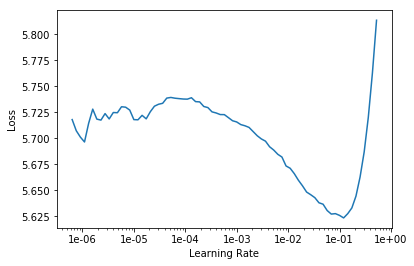

In [0]:
learn.recorder.plot(skip_end=15)

Так как часть слов в словаре новые и сеть про них ничего не знает, то мы начнем обучать только последний слой и embedding-и новых слов

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.623338,4.057502,0.228571,29:25


Сохраняем модель

In [0]:
learn.save('kinopoisk_head')

In [0]:
learn.load('kinopoisk_head')

Посмотрим из каких слоев состоит нейронная сеть

In [0]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60004, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1150]           0          False     
______________________________________________________________________
RNNDropout           [70, 1150]           0          False     
______________________________________________________________________
Linear               [70, 60004]          24,061,604 True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 24,061,604
Total trainable params: 24,061,604
Total non-trainable params: 0

Посмотрим как работает предсказание:

In [0]:
TEXT = "полный эффект присутствия"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

полный эффект присутствия . Фильм снят в необычной манере , музыка не режет слух . Игра актеров завораживает . Актеры сыграли отлично , не подкачали , роль в фильме практически не подошла . Джон Малкович ( Джеймс
полный эффект присутствия , бескрайние просторы Африки , люди , которые в своем роде живут в самом широком , не самом лучшем смысле этого слова , городе . Все они - настоящие , живущие в этой культуре . Все в


In [0]:
TEXT = "полный эффект присутствия"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Фильм снят в необычной манере , музыка не режет слух . Игра актеров завораживает . Актеры сыграли отлично , не было никаких эмоций , которые могли бы вызвать улыбку , но и они не играли . Долго я не могла поверить , что в фильме нет ничего , что могло бы - реально повернуться . Фильм затягивает ,
 
 
  Сюжет закручен на различные члены семьи , которые будут жить счастливо . Но вот на чем режиссер и не падает и не вносит новых красок , как


Теперь мы "разморозим" все слои и продолжим обучение языковой модели

In [0]:
learn.unfreeze()

In [0]:
from fastai.callbacks import SaveModelCallback

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7), 
                    callbacks=[SaveModelCallback(learn, name='best_kinopoisk')])

epoch,train_loss,valid_loss,accuracy,time
0,4.374048,3.758804,0.300000,33:44
1,4.262966,3.546897,0.328571,33:48
2,4.226732,3.489769,0.371429,33:50
3,4.159681,3.341416,0.385714,33:52
4,4.098773,3.390381,0.371429,33:54
5,4.072806,3.288219,0.385714,33:53
6,4.043604,3.259739,0.371429,33:55
7,3.992717,3.264781,0.400000,33:54
8,3.968031,3.251725,0.371429,33:55
9,3.943636,3.248332,0.385714,33:54


Better model found at epoch 0 with val_loss value: 3.7588043212890625.
Better model found at epoch 1 with val_loss value: 3.5468966960906982.
Better model found at epoch 2 with val_loss value: 3.489769220352173.
Better model found at epoch 3 with val_loss value: 3.341416358947754.
Better model found at epoch 5 with val_loss value: 3.2882192134857178.
Better model found at epoch 6 with val_loss value: 3.2597389221191406.
Better model found at epoch 8 with val_loss value: 3.251725435256958.
Better model found at epoch 9 with val_loss value: 3.2483322620391846.


In [0]:
learn.save('kinopoisk_tuned')

In [0]:
learn.load('kinopoisk_tuned');

Качество языковой модели измеряется такой метрикой, как перплексия. В данном случае ее можно посчитать, если взять экспоненту от величины функции потерь на валидационной выборке. Чем меньше перплексия, тем лучше

In [29]:
np.exp(3.248332)

25.74735748752309

Если продолжить обучать модель за один цикл, то loss будет расти

In [0]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.978713,3.911488,0.338658,30:28


Сохраняем Encoder

In [0]:
learn.save_encoder('kinopoisk_tuned_enc')

## Загружаем предобученную модель

А теперь загрузим уже обученную на отзывах модель и поэкспериментируем с ней

In [0]:
learn = language_model_learner(data, arch=AWD_LSTM, pretrained=False, pretrained_fnames=('kinopoisk_tuned', 'kinopoisk_lm_vocab'), path=ROOT_PATH/'kinopoisk')

Посмотрим как работает предсказание

In [27]:
TEXT = "полный эффект присутствия"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.95) for _ in range(N_SENTENCES)))

 
 
  При просмотре
полный эффект присутствия - браво режиссеру , художнику и съемочной группе ! Немного по - другому , фильм просто великолепен ! Потрясающая - картинка , картинка , местами немного квантовой физики сцены с красивыми видами и просто невероятные декорации Мексике : намекают на то , что эффекты здесь подобраны действительно на уровне . Сюжет - созданный в 1993 году


In [0]:
TEXT = "полный эффект присутствия"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

полный эффект присутствия , масштабный и пугающий фильм , который будет следовать всем канонам жанра , интрига , компьютерная графика . История о Бэтмене , которая вновь и вновь знакомит нас с героиней Мэгги Джилленхол ( Энн Хэтэуэй ) . Перед нами предстаёт Джокер , в которого влюбился Джокер , и его сюжет полностью
полный эффект присутствия . Мрачный , жестокий , с интересными диалогами , захватывающий сюжет , колоритные персонажи , красивые костюмы и мрачные декорации . Но это уже не тот фильм , на который я пошёл в кино ... Пожалуй , это один из самых лучших фильмов , которые я видел . Жаль , что не вышел . Это


In [0]:
TEXT = "полный эффект присутствия"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

полный эффект присутствия . Не зря же Питер Джексон на самом деле является режиссером этого фильма , но режиссер Питер Джексон , священник , которого я не видел после просмотра фильма , не смог меня удивить .
полный эффект присутствия . Фильм невероятно яркий , интригующий , не претендующий на звание шедевра , но , на мой взгляд , такой же забавный и линейный . Говоря откровенно , он оправдал все ожидания , и в первую очередь ,


Речь стала намного более связной!

In [30]:

TEXT = "фильм полностью оправдал"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
 
 
  Во - вторых , это замечательный фильм о любви , о том на что можно пойти ради любви к своей матери . Такое кино , особенно
фильм полностью оправдал мои ожидания . После просмотра остались приятные воспоминания , и вновь начинаешь думать , что это не так , но не верится , что в фильме этого не мало . Сюжет довольно простой . Например , в фильме две семьи : Кэти и Джулия . Но если Шон просит Кэти ' уехать ' с ним , то Кэти не может найти себя в этом мире . Она пытается найти ее и стать красивой . Но в то же время


In [0]:
TEXT = "фильм полностью оправдал"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
  Отличный подбор актёров на главную роль . Весь фильм построен на диалогах : одни и те же . Очень понравился тот момент , когда Кристиан Бэйл играет Тома Харди . Кто же будет смотреть на Бэйла ? Он сыграл того самого полицейского , который играл в фильмах , но в целом сыграл в этом фильме не хуже самого Бэйла . Он настолько тираном , что даже не верится , что
 
 
 
 
  10 из 10 xxbos Картина повествует о предысторию , связанной с началом войны в Ираке , когда данный фильм стал классикой американского кинематографа . Картина «


In [0]:
TEXT = "могло быть и"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
  Именно из - за Тоби Магуайра в фильме ' Человек -
 
 
  Но , несмотря на все плюсы , я не могу сказать , что остался доволен . Да , это не фильм ужасов , а скорее не о войне , а о войне . Это странная , страшная , жизненная драма . Но , боюсь , именно этот фильм о том , что такое война , что могут быть другие люди . а еще есть девушка , которую надо убить , чтобы она не любила и не желает заниматься любимым


In [0]:
TEXT = "самый настоящий провал"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 
 
  Начну с того , что фильм , конечно , не скучный , но и не новый . По правде , Marvel - это единственная , вина , которая может быть интересна мне в
самый настоящий провал этого фильма ! Если честно , не ожидал , что это очередная пародия на ту же ' Ночь в музее ' , но в последние годы таким фильмам не хватало одного из лучших фильмов , а на такой ' шедевр ' стоит сходить . По - моему , комиксы тут очень и очень хороши . Также


# Классификация отзывов с Кинопоиска

## Подготовка данных

In [0]:
bs = 48


Важно, чтобы словарь, используемый для классификатора, 
в точности **совпадал со словарем**, который использовалася на этапе обучения **языковой модели**

In [0]:
vocab = Vocab.load(ROOT_PATH/'kinopoisk'/'models'/'kinopoisk_lm_vocab.pkl')

In [0]:
# если у вас уже загрузены данные языковой модели, то можно сделать
# vocab = data.vocab

In [0]:
data_clas = (TextList.from_df(df_all, cols='reviewBody', vocab=vocab)
             .split_from_df('valid')
             .label_from_df(cols='status')
             .databunch(bs=bs))

In [0]:
data_clas.save(DATA_PATH/'kinopoisk_clas_data.pkl')

In [0]:
data_clas = load_data(DATA_PATH, "kinopoisk_clas_data.pkl", bs)

А теперь создадим классификатор

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path=ROOT_PATH/'kinopoisk', pretrained=False)
# Загружаем предварительно обученный encoder
learn.load_encoder('kinopoisk_tuned_enc')

## Обучаем классификатор

Пожалуйста, найдите оптимальный learning rate и обучите модель один цикл этим learning rate с параметром `moms=(0.8, 0.7)`

Сохраните полученную модель под именем 'kp_first'

А теперь мы продолжаем размораживать слои, обучая их "по очереди", начиная с конца.

Мы не хотим сразу разрушить хрупкую структуру Encoder-a, который был обучен на предыдущем шаге.

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-2/(2.6**4),3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.184148,0.117084,0.958722,04:16


In [0]:
learn.save('kp_second')

In [0]:
learn.load('kp_second');

Продолжаем обучать модель, размораживая следующие слои

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.141272,0.106738,0.960053,06:24


In [0]:
learn.save('kp_third')

In [0]:
learn.load('kp_third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.111156,0.106131,0.958189,08:03


Мы натренировали нашу сеть, которая **с высокой точностью (96%)** определяет "тональность" отзыва

Можно загрузить уже обученный заранее классификатор:

In [0]:
learn.load('kinopoisk_clas_tuned');

Давайте проверим ее на случайном отызыве с кинопоиска

In [0]:
# Пример положительного отзыва

learn.predict('''
«Балканский рубеж» в некотором роде уникальный фильм для нашего синематографа последнего времени. И вот почему, с одной стороны мы снимаем по лекалам телефильмов о доблестном спецназе кино, которое при прочих равных прошло бы более или менее не замеченным, а с другой стороны обозначаем проблему сосуществования народов и этнических войн на территории бывшей Югославии. К данной теме я вообще не равнодушен и было интересно взглянуть, как отечественный режиссер покажет эти моменты. И получилось совсем не плохо, по крайней мере, у меня не возникает чувства непонимания, что происходило в Боснии и Косово. Да, широкими мазками обозначена проблема, зато доходчиво донесено, что испытывали простые люди при развале страны. 

После конфликта во взаимодействии с силами НАТО, члены разведовательно — диверсионной группы оказываются в непростой ситуации и вынуждены остаться вне пределов России. Каждый устраивается по своему в новой жизни и старается выжить. Но изменение вектора политической обстановки вновь делает их востребованными Отечеством. Надо занять и удержать аэропорт Приштины в Косово, до подхода российских миротворцев. Захват и удержание показаны в добротной манере отечественных сериалов, останавливаться на этом не буду, меня больше порадовали второстепенные линии сюжета. Возможно, сотрудничество с сербами сделали эти линии проникновенными с чисто человеческого восприятия. Это и драма в роддоме при налетах НАТО, и непростые отношения косоваров и сербов на примере полицейского поста в Косово, и этническо — конфессиональные расстрелы, и напряжение до срывов медработников от вида пострадавших — говорят война все спишет, это так. Только вот рубцов и ран в душах людей не излечит даже время, боль и горечь потерь близких и друзей долго будет жить в памяти. 

Переплетение реальных фактов и художественного вымысла неплохо сочеталось в этой ленте — марш-бросок на Приштину десантников удачно дополнил бой группы Бека, восторги сербов на кадрах хроники и киношные смотрелись органично. Что касается политических перипетий, то это дело грязное и идеологический контекст можно и пропустить при просмотре, хотя ничего нереального в показанном я не увидел. Порадовали показанные будни десантников, под «Сектор газа» смотрелось реалистично, вполне реальное развлечение для отвлечения от повседневной рутины.

Актеры сыграли в целом нормально и наши и сербские, из наших мне понравились Куркова, Полухин и Марин, из сербов Гойко Митич, Бикович и Родойичич. Специфический юмор только усилил игру актеров. Кустурица в концовке тоже смотрелся к месту. В целом, не проявив чудес актерского мастерства все смотрелись не плохо. 

Минусы конечно есть и довольно жирные, в основном связаны с навязыванием определенного идеологического подтекста, и увы, незнанием особенностей службы в войсках специального назначения. Но в целом фильм они не уродуют, поэтому смело отношу его к положительным моментам нашего кинопроката.
''')

(Category good, tensor(1), tensor([0.0708, 0.9292]))

In [0]:
# Пример отрицательного отзыва

learn.predict('''
Пусть видят, кто против них (с)

В конце 90-ых, во время очередного конфликта между сербами и албанцами, российская спецгруппа, находящаяся на территории Югославии, получает приказ захватить местный аэропорт и удержать его до прихода наших миротворцев.

Режиссер «Танцев насмерть» и «Спирали», посредственных, никому ненужных картин, Андрей Волгин на западе давно бы оказался у разбитого корыта и пошел бы на прорыв, получив последний шанс или вошел бы в какую-нибудь когорту создателей сериалов, где ты просто один из тех, кто визуализирует чужие идеи. У нас же все совершенно по-другому произошло… Волгин получил большой бюджет, материал и не самых последних актеров, и что же он из этого смастерил? Все самое наипростейшее… Мотивы героев, как и предсказуемость сюжетных ходов и выпрыгивания спецэффектов из-за ушла — все это уже миллион раз использованные другими ходы, причем и реализованные сверхстандартно и стерильно. Ведь если у тебя есть антагонист, то кроме как дать ему нож и возможность оправдать рейтинг 16+ — единственный вариант продемонстрировать его характер и жестокость. Так же и с другими героями, один поет, другой постоянно про пенсию говорит, третий хочет денег, а узбечка заглянула на проект в поисках мужика, так и работают. А зрителям еще нужно разбираться причем тут НАТО, кто виноват и что делать, в общем не считая плохих дорог здесь есть все классические вопросы, волнующие русских на протяжении веков.

По какой-то совершенно непонятной причине главную роль в «Балканском рубеже» исполнил Антон Пампушный («Защитники») — парень, конечно, колоритный, но с одной эмоцией на лице на любое происшествие и действие в его (их) сторону. Странно видеть таким потерянным Милоша Биковича («Лед»), у него здесь ключевая драматическая роль, но он так все это преподносит, что хочется снять ему скальп ничуть не меньше, чем террористам, которые гоняются за ним. Красивую Милену Радулович («Однажды летней ночью») при любой возможности раздевают, а героиня Равшаны Курковой («Без границ») получилась не только крутой, но еще и с юморком. Одного из самых запоминающихся бойцов с нашей стороны сыграл Сергей Марин («Анна-детективъ»), его неоднозначности и крутости, могли бы позавидовать и заграничные коллеги. Для увесистости в фильм влились: Гоша Куценко («Параграф 78»), которому очень нравится собирать себе отряды, любимейший югослав старшего поколения Гойко Митич («Апачи») и вечный Эмир Кустурица («Время цыган»). 

Картина «Балканских рубеж» очевидно снята явно из хороших побуждений и желания сделать, что-то свое на уровне Бэя и его «13 часов». Главные герои — такие наши Джеймсы Бонды без фантастической составляющей. Но вот снят «Балканский рубеж» самым скучным и потребительским образом: с кучей слоу-мо, увидев его количество даже создатели «Т-34» тихо стоят и покуривать в сторонке, хотя попытку сыграть в масштаб и серьезность можно и зачесть. Правда дешевые спецэффекты и длиннющие диалоги с попыткой хоть как-то раскрыть героев портят этот и так слишком затянутый фильм с нелогичным кастингом и музыкой, которая убаюкивает зрителей постоянно повторяющимся мотивом.''')

(Category bad, tensor(0), tensor([0.9820, 0.0180]))

In [0]:
learn.predict('Очень хороший фильм')

(Category good, tensor(1), tensor([0.0130, 0.9870]))

In [0]:
learn.predict('Почему то мне кажется, что фильм далек от идеала. Я бы не советовал его смотреть')

(Category bad, tensor(0), tensor([0.9311, 0.0689]))

In [0]:
learn.predict('''
              Фильм показался мне ужасным.
              Это невероятное чувство плохой игры актеров.
              Не рекомендую смотреть
              ''')

(Category bad, tensor(0), tensor([0.9855, 0.0145]))

In [0]:
learn.predict("Лучший фильм, который я когда-либо смотрел!")

(Category good, tensor(1), tensor([0.2370, 0.7630]))

In [0]:
learn.predict("Это худший фильм, который я когда-либо смотрел. Такие дела. Хотя может быть и стоит посмотреть фанатам")

(Category bad, tensor(0), tensor([0.9627, 0.0373]))

## Интерпритируем результаты работы

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

True

Пары классов, которые сеть путает больше всего

In [0]:
interp.most_confused()

[('bad', 'good', 74), ('good', 'bad', 44)]

Посмотрим на матрицу ошибок:

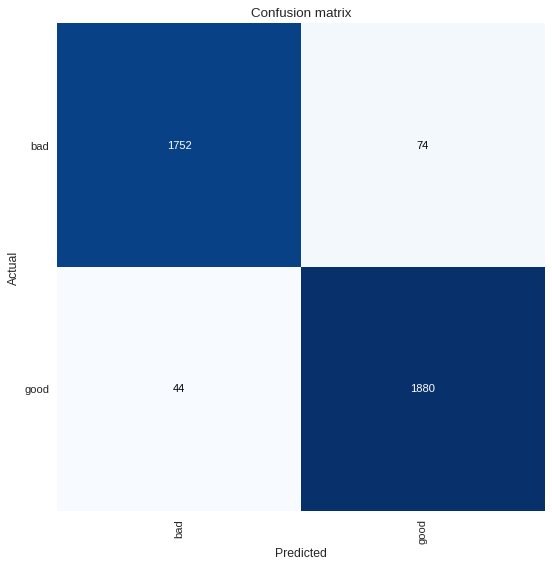

In [0]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=80)

In [0]:
learn.predict('Это ужасный фильм. И как это я мог такое смотреть? Крайне не рекомендую')

(Category bad, tensor(0), tensor([9.9927e-01, 7.3213e-04]))